# Seasonality and holiday effect decomposition

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

plt.rcParams["figure.figsize"] = (13, 15)

In [220]:
btc_data = pd.read_parquet('../2_data_processing/numeric_data/btc_numeric_data.parquet.gzip')
eth_data = pd.read_parquet('../2_data_processing/numeric_data/eth_numeric_data.parquet.gzip')

In [221]:
btc_price = (btc_data
             .btc_price_close
             .dropna()
             .reset_index())

eth_price = (eth_data
             .eth_price_close
             .dropna()
             .reset_index())


In [222]:
for df in [btc_price, eth_price]:
    df['datetime'] = df['index'].apply(datetime.utcfromtimestamp)
    df.drop(columns='index', inplace=True)
    df.rename(columns={'datetime':'ds',
                       'btc_price_close': 'y',
                       'eth_price_close':'y',
                       },
              inplace=True)

## Using Facebook's Prophet

In [ ]:
!pip install prophet cmdstanpy

Important: Need to run this in prophet directory to make model work:

```
install_name_tool -add_rpath @executable_path/cmdstan-2.26.1/stan/lib/stan_math/lib/tbb ~/.tsf-env/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin
```

In [223]:
from prophet import Prophet

In [224]:
btc_model = Prophet(seasonality_mode = 'multiplicative')
btc_model.add_country_holidays(country_name='US')
btc_model.fit(btc_price)

eth_model = Prophet(seasonality_mode = 'multiplicative')
eth_model.add_country_holidays(country_name='US')
eth_model.fit(eth_price)

11:29:45 - cmdstanpy - INFO - Chain [1] start processing
11:29:46 - cmdstanpy - INFO - Chain [1] done processing
11:29:46 - cmdstanpy - INFO - Chain [1] start processing
11:29:47 - cmdstanpy - INFO - Chain [1] done processing


In [225]:
btc_future = btc_model.make_future_dataframe(0)
eth_future = eth_model.make_future_dataframe(0)

In [226]:
btc_forecast = btc_model.predict(btc_future)
eth_forecast = eth_model.predict(eth_future)

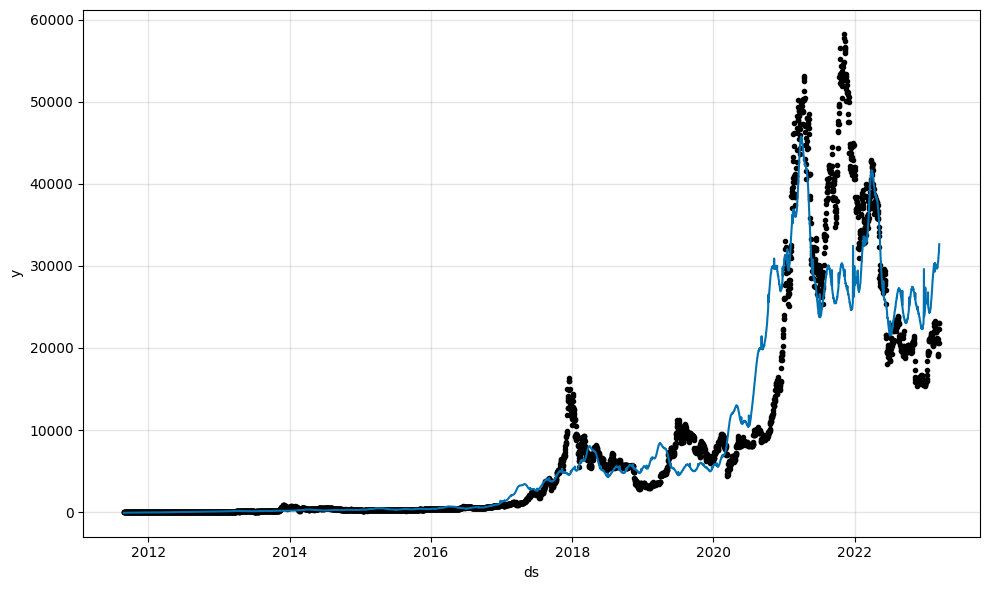

In [227]:
btc_model.plot(btc_forecast, uncertainty=False);

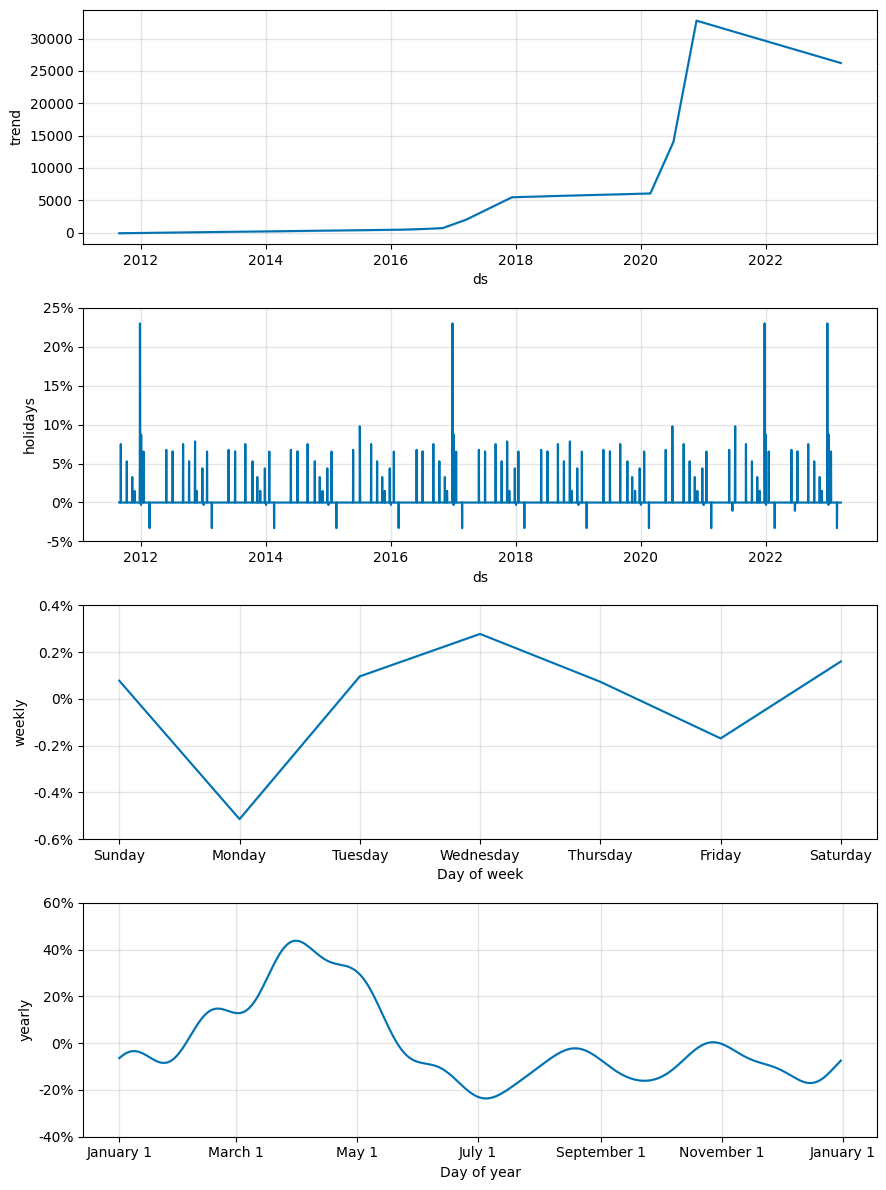

In [228]:
btc_model.plot_components(btc_forecast);

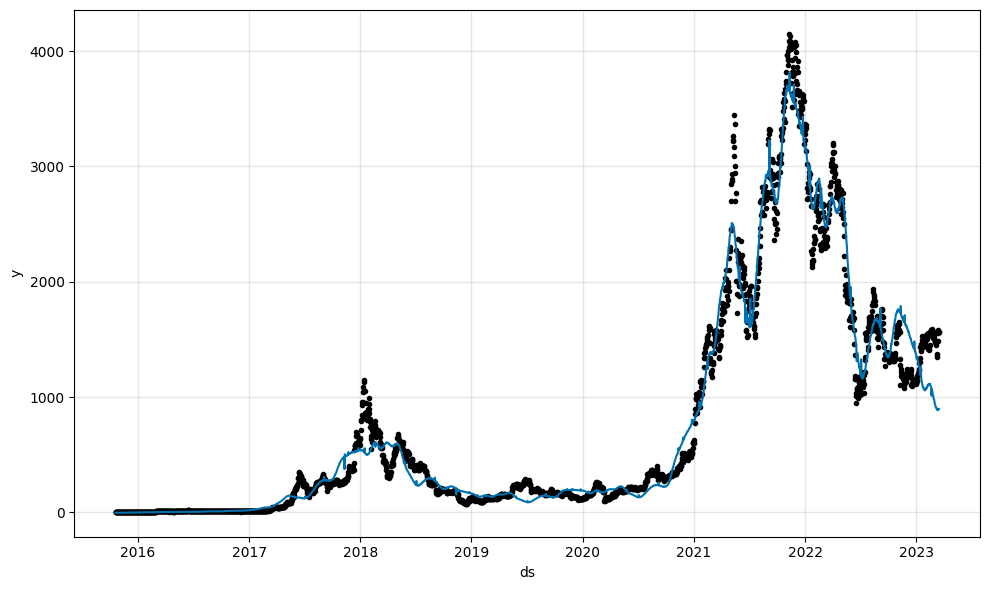

In [229]:
eth_model.plot(eth_forecast, uncertainty=False);

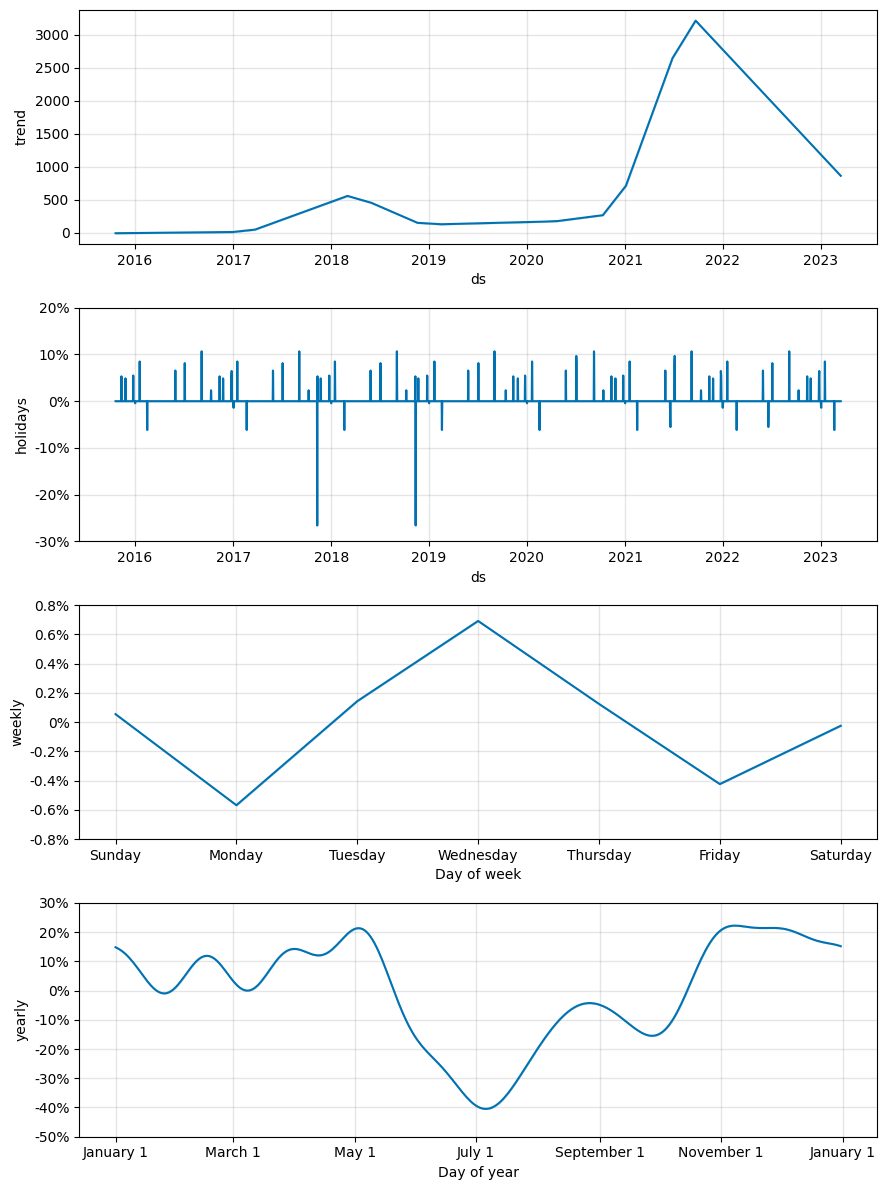

In [230]:
eth_model.plot_components(eth_forecast);

## Using MSTL

In [231]:
from statsmodels.tsa.seasonal import MSTL

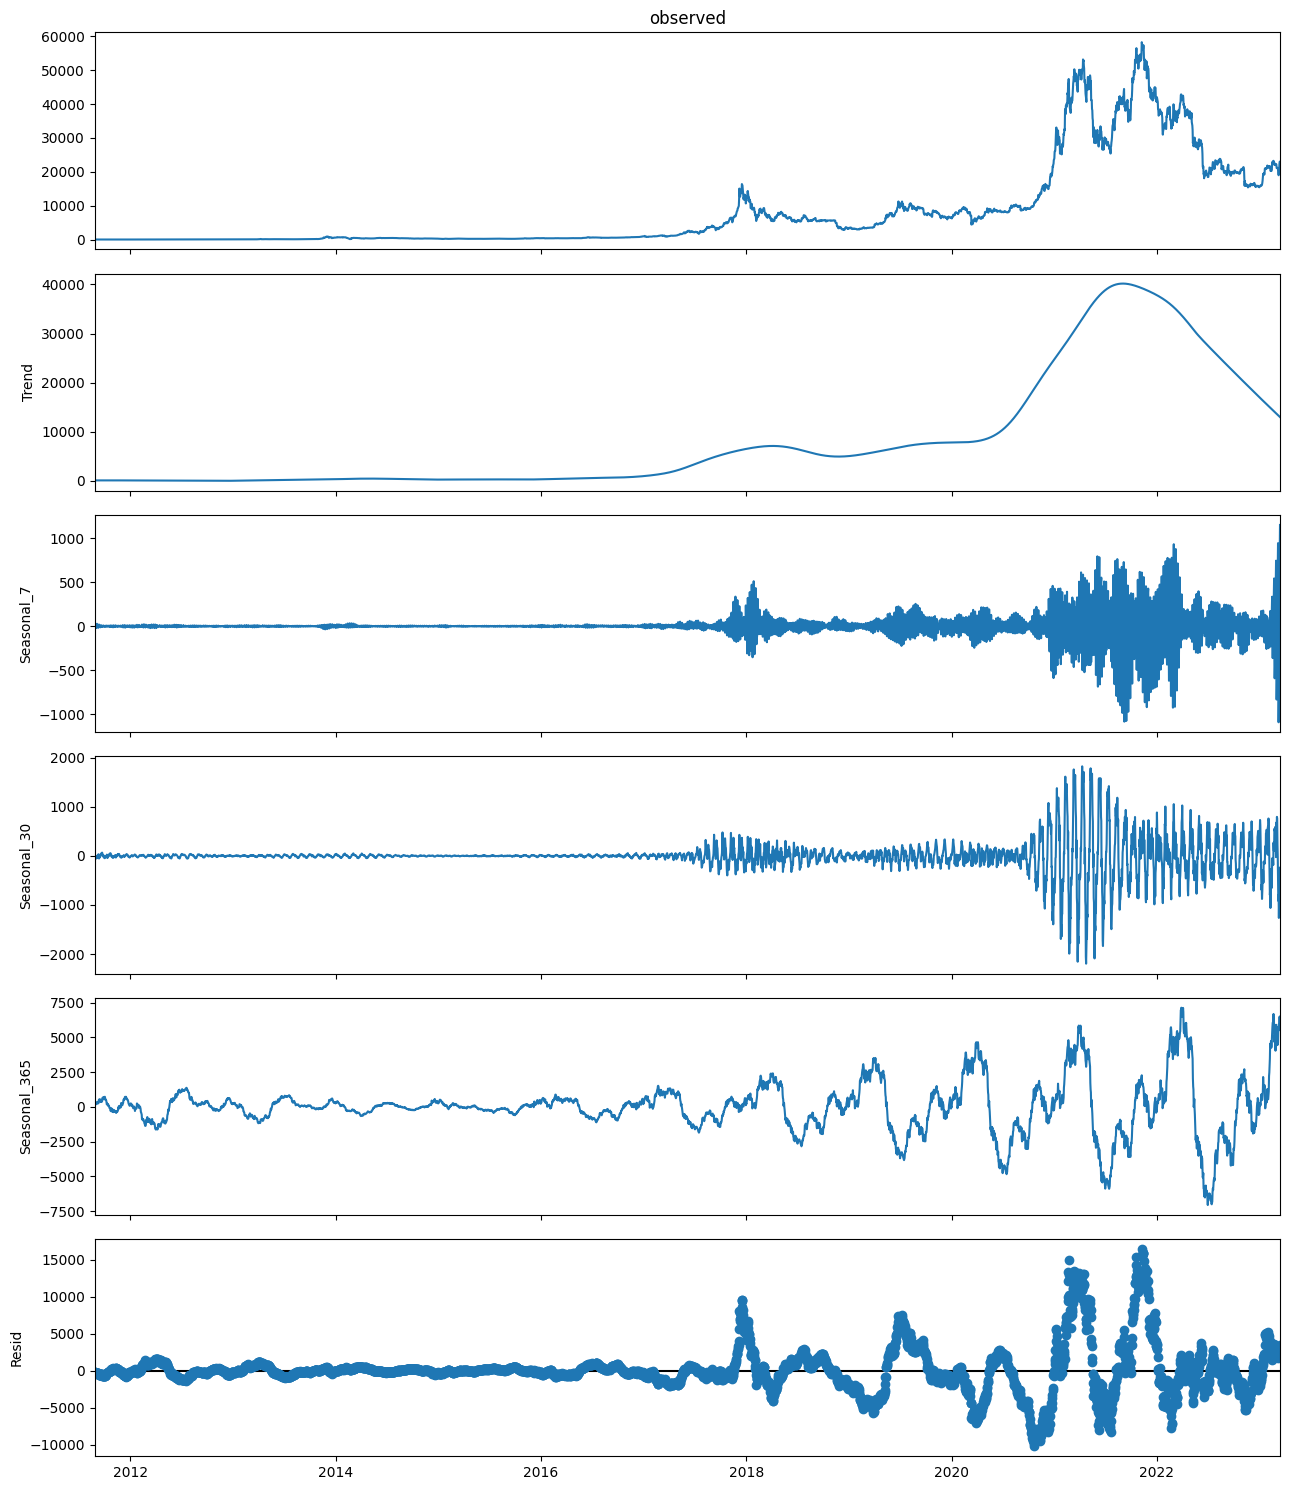

In [232]:
model = MSTL(btc_price.set_index('ds').y, periods=(7, 30, 365))
result = model.fit()
result.plot();

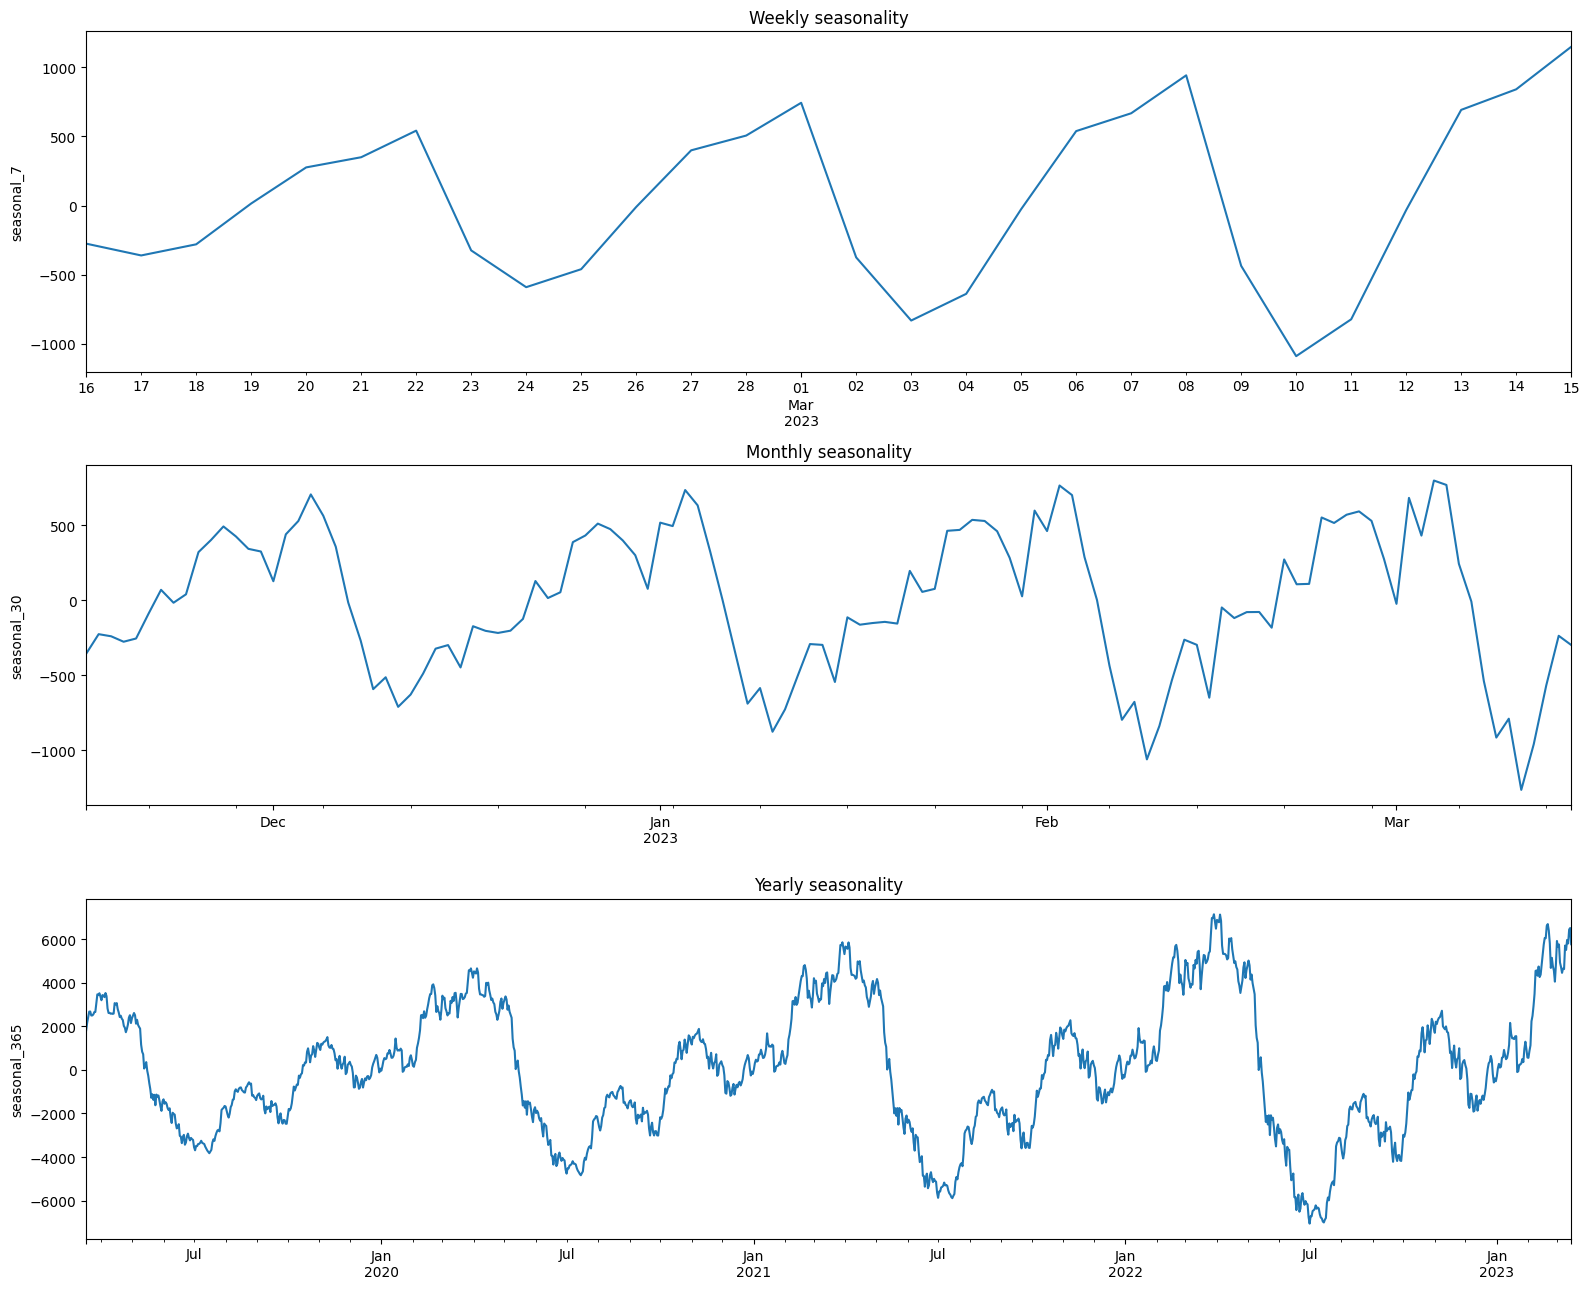

In [233]:
fig, ax = plt.subplots(nrows=3, figsize=[16,13])
result.seasonal['seasonal_7'].iloc[-7*4:].plot(ax=ax[0])
ax[0].set_ylabel('seasonal_7')
ax[0].set_xlabel('')
ax[0].set_title('Weekly seasonality')

result.seasonal['seasonal_30'].iloc[-30*4:].plot(ax=ax[1])
ax[1].set_ylabel('seasonal_30')
ax[1].set_xlabel('')
ax[1].set_title('Monthly seasonality')

result.seasonal['seasonal_365'].iloc[-365*4:].plot(ax=ax[2])
ax[2].set_ylabel('seasonal_365')
ax[2].set_xlabel('')
ax[2].set_title('Yearly seasonality')

plt.tight_layout()

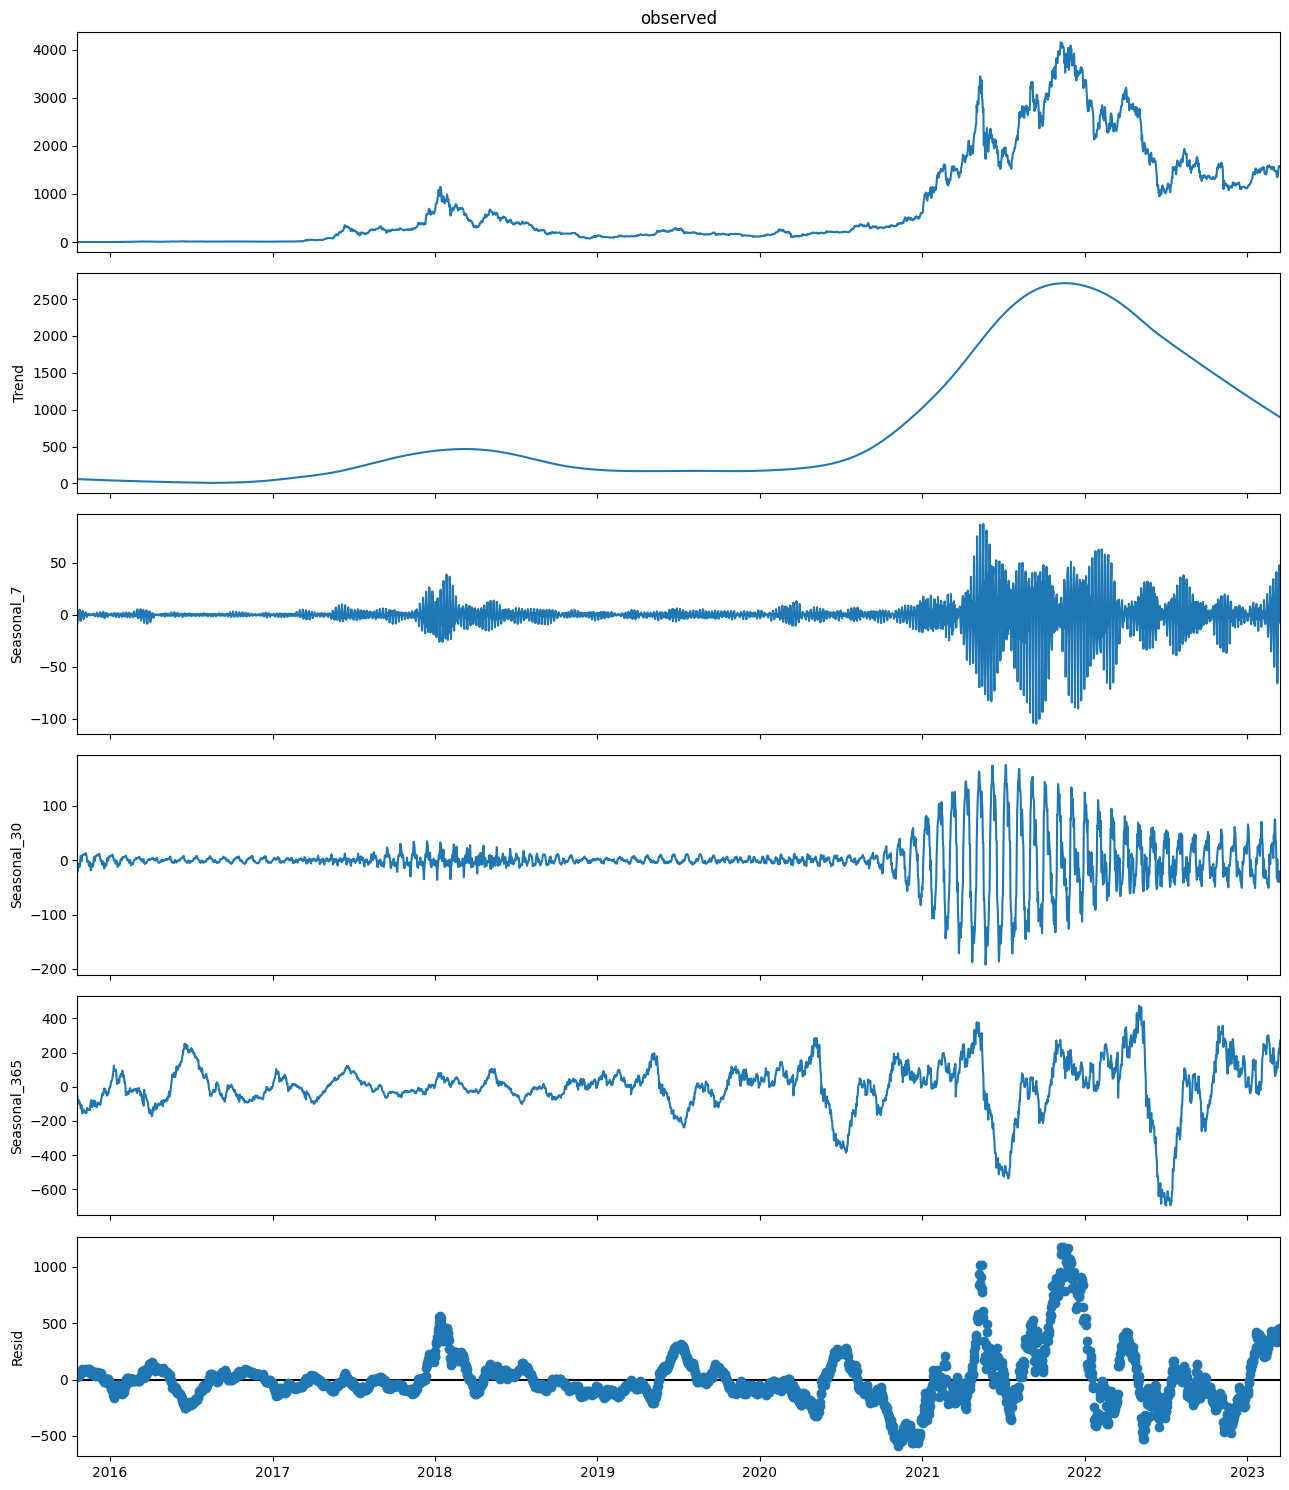

In [237]:
model = MSTL(eth_price.set_index('ds').y, periods=(7, 30, 365))
result = model.fit()
result.plot();

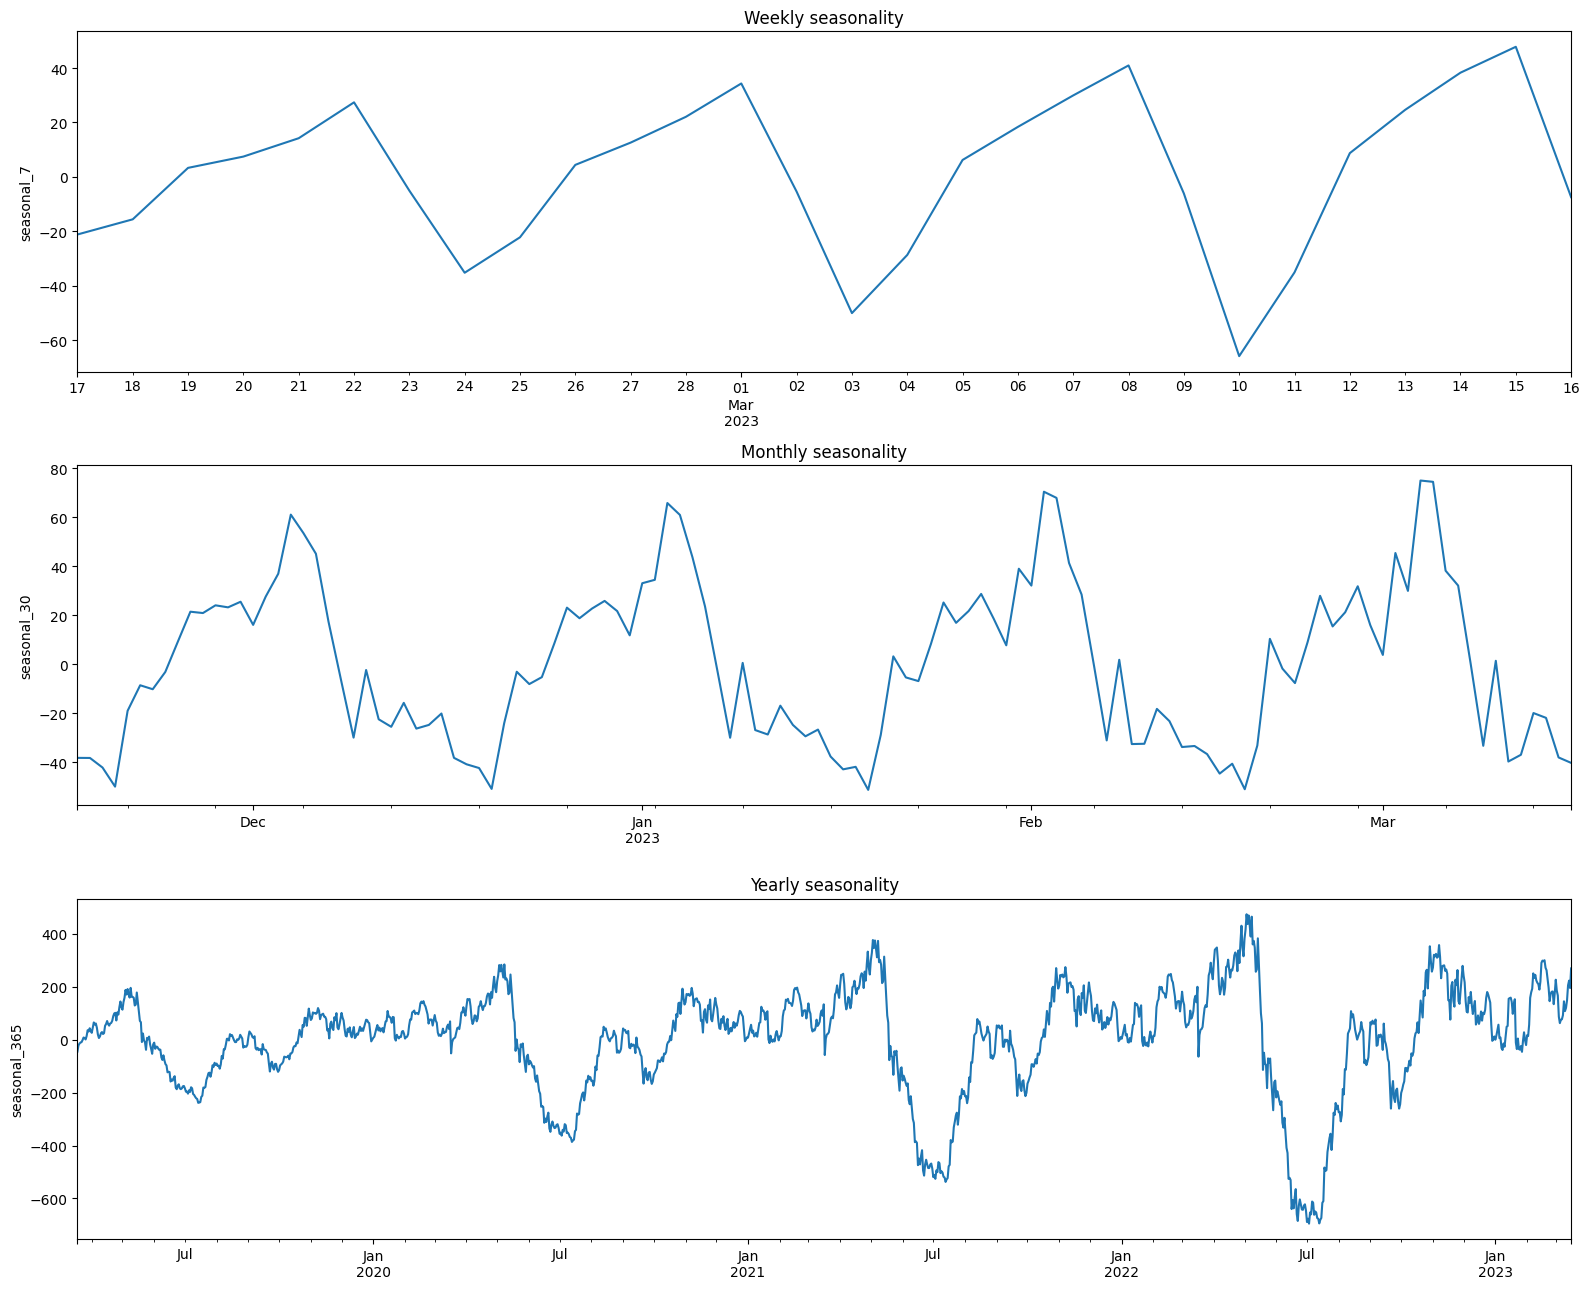

In [235]:
fig, ax = plt.subplots(nrows=3, figsize=[16,13])
result.seasonal['seasonal_7'].iloc[-7*4:].plot(ax=ax[0])
ax[0].set_ylabel('seasonal_7')
ax[0].set_xlabel('')
ax[0].set_title('Weekly seasonality')

result.seasonal['seasonal_30'].iloc[-30*4:].plot(ax=ax[1])
ax[1].set_ylabel('seasonal_30')
ax[1].set_xlabel('')
ax[1].set_title('Monthly seasonality')

result.seasonal['seasonal_365'].iloc[-365*4:].plot(ax=ax[2])
ax[2].set_ylabel('seasonal_365')
ax[2].set_xlabel('')
ax[2].set_title('Yearly seasonality')

plt.tight_layout()

## Conclusion

Significant weekly, monthly and yearly seasonality is observed, at least since 2020. Price dips on Friday, in the beginning of the month and in July consistenly for both cryptocurrencies. Furthermore, significant holiday effects are observed. Day of week, day of month, month of year and holidays should therefore be included as explanatory variables for forecasting.